In [93]:
%load_ext autoreload

%autoreload 2

import sys
from pathlib import Path

# Ensure project imports work when launching the notebook from this subdirectory.
for candidate in (Path.cwd(), *Path.cwd().parents):
    if (candidate / "experiments.py").exists():
        path_str = str(candidate)
        if path_str not in sys.path:
            sys.path.insert(0, path_str)
        break
else:
    raise RuntimeError("Could not locate repository root")

import numpy as np
from tqdm.auto import tqdm

from lyapunov import has_lyapunov, bisection
from pepit_helpers import worst_case_performance
from plotting import line_plot
from utils import dask_parallel_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PEPit certificates for the validity of Theorem 1
This notebook provides an easy way of checking the validity of the statements in Theorem 1 numerically using PEPit. We verify the formula of the following:
- The optimal step size 
- The worst case convergence rate 
- The optimal Lyapunov function

In [ ]:
# Experiment settings: feel free to play around with these
# NOTE: the Lyapunov function search is quite sensitive to the conditioning of the function
L = 1.0
mu = 0.1
eps = 1e-2  # WARNING: problems with conditioning for small epsilon, so we use this as a lower bound
epsilons = np.linspace(eps, 1 - eps, num=10)
TOL = 1e-5

## Optimal step size
We claim that the optimal step size for EF is given exactly by
$$
\eta^\star = \left(\frac{2}{L+\mu}\right) \cdot \left(\frac{1 - \sqrt{\epsilon}}{1 + \sqrt{\epsilon}}\right).
$$
In order to validate that claim, we measure the best worst-case contraction for a sequence of $\epsilon \in (0, 1)$ over a grid of step sizes $\eta \in (0, \frac{2}{L+\mu})$, and compare it in a line plot with the formula given.

In [101]:
optimal_step_sizes = []
for epsilon in tqdm(epsilons):

    # Find the optimal step size over grid
    step_sizes = np.linspace(eps, 2 / (L + mu), num=400)  # NOTE: adjust resolution here depending on your hardware

    # Compute the contraction factors over those step sizes
    contractions = dask_parallel_map(
        lambda eta: bisection(0, 1, tol=TOL, solving_fun=has_lyapunov, delta=1 - epsilon, eta=eta, mu=mu, L=L, method="EF", use_residual=True)[0],
        step_sizes,
        show_progress=False
    )
    contractions = np.array([np.nan if c is None else c for c in contractions])
    best_eta = np.nan if np.all(np.isnan(contractions)) else step_sizes[np.nanargmin(contractions)]
    optimal_step_sizes.append(best_eta)

100%|██████████| 10/10 [01:17<00:00,  7.80s/it]


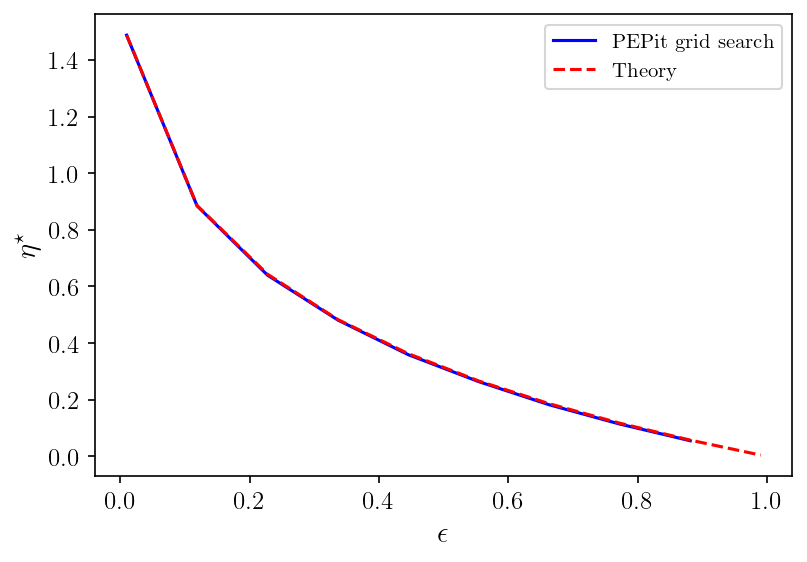

In [102]:
def theory_step_size(epsilon, L, mu):
    return 2 / (L + mu) * (1 - np.sqrt(epsilon)) / (1 + np.sqrt(epsilon))

theory = np.array([theory_step_size(epsilon, L, mu) for epsilon in epsilons])
data = [
    (epsilons, optimal_step_sizes, {"linestyle": "-", "label": "PEPit grid search", "color": "blue"}),
    (epsilons, theory, {"linestyle": "--", "label": "Theory", "color": "red"})
]

line_plot(
    data,
    figsize=(6, 4),
    xlabel=r"$\epsilon$",
    ylabel=r"$\eta^\star$",
    plt_legend=True,
)

## Convergence rate
We claim that the worst-case convergence rate is given by
$$
\rho^\star = \sqrt{\epsilon} + \frac{1}{4} (1 + \sqrt{\epsilon}) (L - \mu) \lambda,
$$
where
$$
\lambda \coloneqq \frac{\eta^\star}{L+\mu} \left[(1 - \sqrt{\epsilon})(L - \mu) + (1 + \sqrt{\epsilon}) \sqrt{(L - \mu)^2 + 16 L \mu \frac{\sqrt{\epsilon}}{(1 + \sqrt{\epsilon})^2}} \right].
$$
In order to validate that claim, we use the step size above, measure the worst-case contraction over a sequence of $\epsilon \in (0, 1)$, and print the highest relative difference between the formula and our measurements.

In [97]:
rho_measured = []
for epsilon in tqdm(epsilons):
    eta = theory_step_size(epsilon, L, mu)
    rho = bisection(0, 1, tol=TOL, solving_fun=has_lyapunov, delta=1 - epsilon, eta=eta, mu=mu, L=L, method="EF", use_residual=True)[0]
    rho_measured.append(rho)

100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


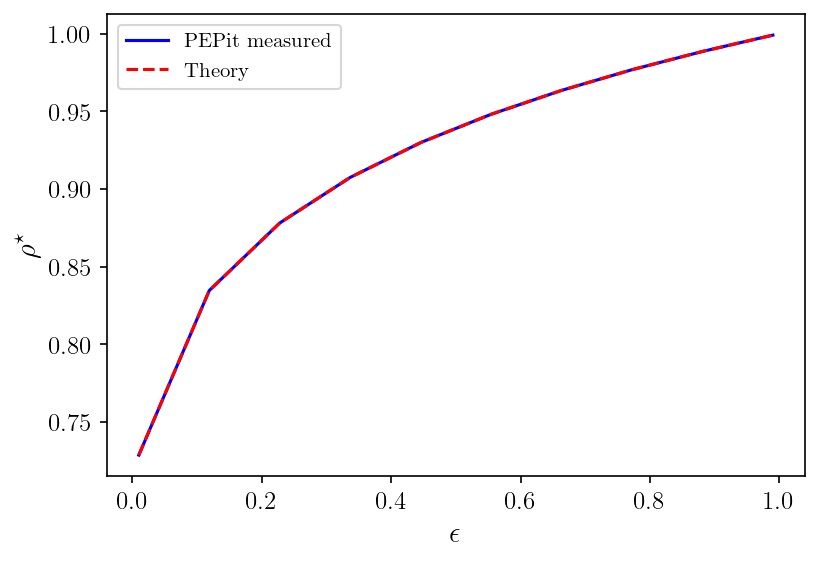

In [98]:
def theory_rate(epsilon, L, mu):
    sqrt_eps = np.sqrt(epsilon)
    eta_star = theory_step_size(epsilon, L, mu)
    delta_L = L - mu
    inner_sqrt = delta_L ** 2 + 16 * L * mu * (sqrt_eps / (1 + sqrt_eps) ** 2)
    lam = (eta_star / (L + mu)) * ((1 - sqrt_eps) * delta_L + (1 + sqrt_eps) * np.sqrt(inner_sqrt))
    return sqrt_eps + 0.25 * (1 + sqrt_eps) * delta_L * lam

# Compare measured vs theoretical convergence rates
rho_measured_np = np.array([
    r[0] if isinstance(r, tuple) else r for r in rho_measured
], dtype=float)

rho_theory = np.array([theory_rate(epsilon, L, mu) for epsilon in epsilons], dtype=float)

data = [
    (epsilons, rho_measured_np, {"linestyle": "-", "label": "PEPit measured", "color": "blue"}),
    (epsilons, rho_theory, {"linestyle": "--", "label": "Theory", "color": "red"}),
]

line_plot(
    data,
    figsize=(6, 4),
    xlabel=r"$\epsilon$",
    ylabel=r"$\rho^\star$",
    plt_legend=True,
)

## Lyapunov function
We claim that a Lyapunov function achieving the announced rate is given by
$$
\|x - x_\star\|^2 - 2 (x - x_\star)^\top e + \left(1 + \frac{1}{\sqrt{\epsilon}}\right) \cdot \|e\|^2 = \|x - x_\star - e\|^2 + \frac{1}{\sqrt{\epsilon}} \|e\|^2.
$$
In order to validate that claim, we measure the rates achieved using specifically this Lyapunov function over a sequence of $\epsilon \in (0, 1)$, and print the highest relative difference between the rates and the formula detailed above.

In [99]:
rhos_unconstrained = []
rhos_constrained = []
for epsilon in tqdm(epsilons):
    eta = theory_step_size(epsilon, L, mu)

    # First, we measure the unconstrained rate (for any Lyapunov function in our state space)
    rho_unconstrained = bisection(0, 1, tol=TOL, solving_fun=has_lyapunov, delta=1 - epsilon, eta=eta, mu=mu, L=L, method="EF", use_residual=True)[0]
    rhos_unconstrained.append(rho_unconstrained)

    # This lets us directly optimize for the worst-case contraction since we already know the Lyapunov function to evaluate
    rho_constrained = worst_case_performance(mu=mu, L=L, eta=eta, delta=1 - epsilon, method="EF", n_iterations=1, use_simplified=True)
    rhos_constrained.append(rho_constrained)

100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


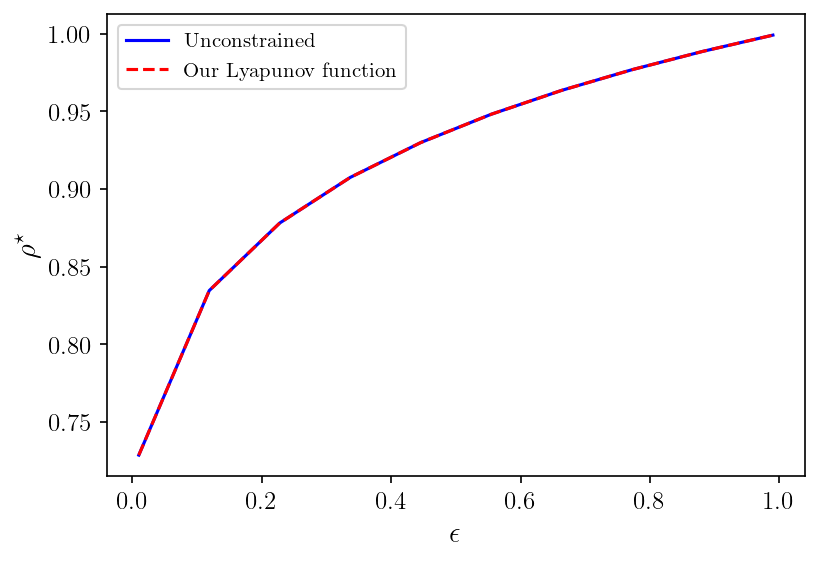

In [100]:
data = [
    (epsilons, rhos_unconstrained, {"linestyle": "-", "label": "Unconstrained", "color": "blue"}),
    (epsilons, rhos_constrained, {"linestyle": "--", "label": "Our Lyapunov function", "color": "red"}),
]

line_plot(
    data,
    figsize=(6, 4),
    xlabel=r"$\epsilon$",
    ylabel=r"$\rho^\star$",
    plt_legend=True,
)